*   Arianna Galzerano 
*   Francesco Fulco Gonzales
*   Alberto Latino



# Importing Libraries and Data

In [ ]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
import random
import json
import cv2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Fixed seed to reproduce computation
SEED = 1234
tf.random.set_seed(SEED)
cwd = os.getcwd()

In [ ]:
# Cell necessary when working on Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell in which it unzips given the directory
!unzip -n 'drive/My Drive/DeepLearning/Data/VQA_Dataset.zip'

# Processing and organization of the dataset

In [ ]:
!ls

drive	sample_data	     train_questions_annotations.json
Images	test_questions.json


In [ ]:
#resizing of images
img_h = 400
img_w = 700

with open(cwd+'/train_questions_annotations.json', 'r') as f:
  files = json.load(f)
      
f.close()

In [ ]:
#switcher to display the 58 possible answers
switcher = {
    '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [ ]:
questions = []

for key in files:
    item = files.get(key)
    questions.append(item['question'])   

## Application of Tokenizer on the questions

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 4640

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(questions)
tokenized = tokenizer.texts_to_sequences(questions)

wtoi = tokenizer.word_index
print('Total words:', len(wtoi))

max_questions_length = max(len(sentence) for sentence in tokenized)
print('Max sentence length:', max_questions_length)

Total words: 4640
Max sentence length: 21


In [ ]:
padded_inputs = pad_sequences(tokenized, maxlen=max_questions_length)
#padded_inputs

In [ ]:
np_files = np.array(list(files.values()))
#np_files

In [ ]:
i=0
for k in np_files:
  k['question']=padded_inputs[i]
  i=i+1
  if i == 58832:
    break

## Custom Generator 


In [ ]:
#cv2 library was used to retrieve images
def retrieve_image(img_name):
    path = 'Images/'+img_name+'.png'
    img = cv2.imread(path)
    #cv2_imshow('image',img)
    return(img)

In [ ]:
#Method that generates the one_hot answer for classification
def decode_one_hot(data, num_classes=58):
    zer = np.zeros((num_classes,),dtype=float)
    zer[data] = 1 
    return zer

In [ ]:
#This function retrieves from the dataset the corresponding 
#Image-Question-Answer block. In it we create the batches of inputs, 
def batch_generator(bfiles, batch_size = 56):
    
    while True:
        
        batch_paths = np.random.choice(bfiles, batch_size)
        X_images_input = []
        X_question_input = []
        y_output = []
        
        for el in batch_paths: 
            x_question=el['question']
            y_answer=switcher.get(el['answer'],0)
            y_answer=decode_one_hot(y_answer)
            
            x_image = retrieve_image(el['image_id'])
            
            X_images_input = X_images_input + [ x_image ]
            X_question_input = X_question_input + [ x_question ] 
            y_output = y_output + [y_answer]
            
        X_images_batch = np.array( X_images_input )
        X_questions_batch = np.array( X_question_input )
        y_batch = np.array( y_output )
        
        #print(X_images_batch, X_questions_batch, y_batch)
        yield ([X_images_batch, X_questions_batch], y_batch)

In [ ]:
#Split train dataset into training and validation (numbers are computed considering 85%-15% splitting)

train_arr, val_arr = train_test_split(np_files,
                                          test_size=.15,
                                          shuffle=True,
                                          random_state=1234)
len(train_arr)+len(val_arr)

58832

In [ ]:
#We created one generator for training and one for validation 
bs=70 #we also tried 56, and with 80 memory availability exceeds
train_gen=batch_generator(train_arr, bs)
valid_gen=batch_generator(val_arr, bs)

# Building the model


##CNN for the image data processing

In [ ]:
#VGG19 import for Transfer Learning 
VGG = tf.keras.applications.VGG19(input_shape=(img_h, img_w, 3), include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

model = Sequential()

for layer in VGG.layers:
    model.add(layer)
for layer in model.layers: # all layers of VGG are set to non-trainable
    layer.trainable = False


model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(4096, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 700, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 700, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 350, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 350, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 350, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 175, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 175, 256)     2

# Recurrent Neural Network for text data processing

In [ ]:
embedding_dim = 64

mod =tf.keras.Sequential()
mod.add(tf.keras.layers.Embedding(len(wtoi)+1, embedding_dim, input_length=max_questions_length))
mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512, return_sequences=True, input_shape=(max_questions_length, embedding_dim))))
#mod.add(tf.keras.layers.Dropout(0.2)) #
mod.add(tf.keras.layers.LSTM(units=512, return_sequences=False))
#mod.add(tf.keras.layers.Dropout(0.2)) #
mod.add(tf.keras.layers.Dense(1024, activation='tanh'))

mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 64)            297024    
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 1024)          2363392   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
Total params: 6,333,504
Trainable params: 6,333,504
Non-trainable params: 0
_________________________________________________________________


## Concatenation of the two models

In [ ]:
from keras.layers.merge import Concatenate

combined = tf.keras.layers.concatenate([model.output, mod.output])

In [ ]:
num_classes=58

model_all=tf.keras.layers.Dense(units=1024, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(combined)
model_all=tf.keras.layers.Dropout(0.1)(model_all) ### era 0.2
model_all = tf.keras.layers.Dense(units=num_classes, activation='softmax')(model_all)

model_final = tf.keras.Model(inputs=[model.input, mod.input], outputs=model_all)

In [ ]:
#Let's visualize the final model 
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 400, 700, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 400, 700, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 200, 350, 64) 0           block1_conv2[1][0]               
______________________________________________________________________________________________

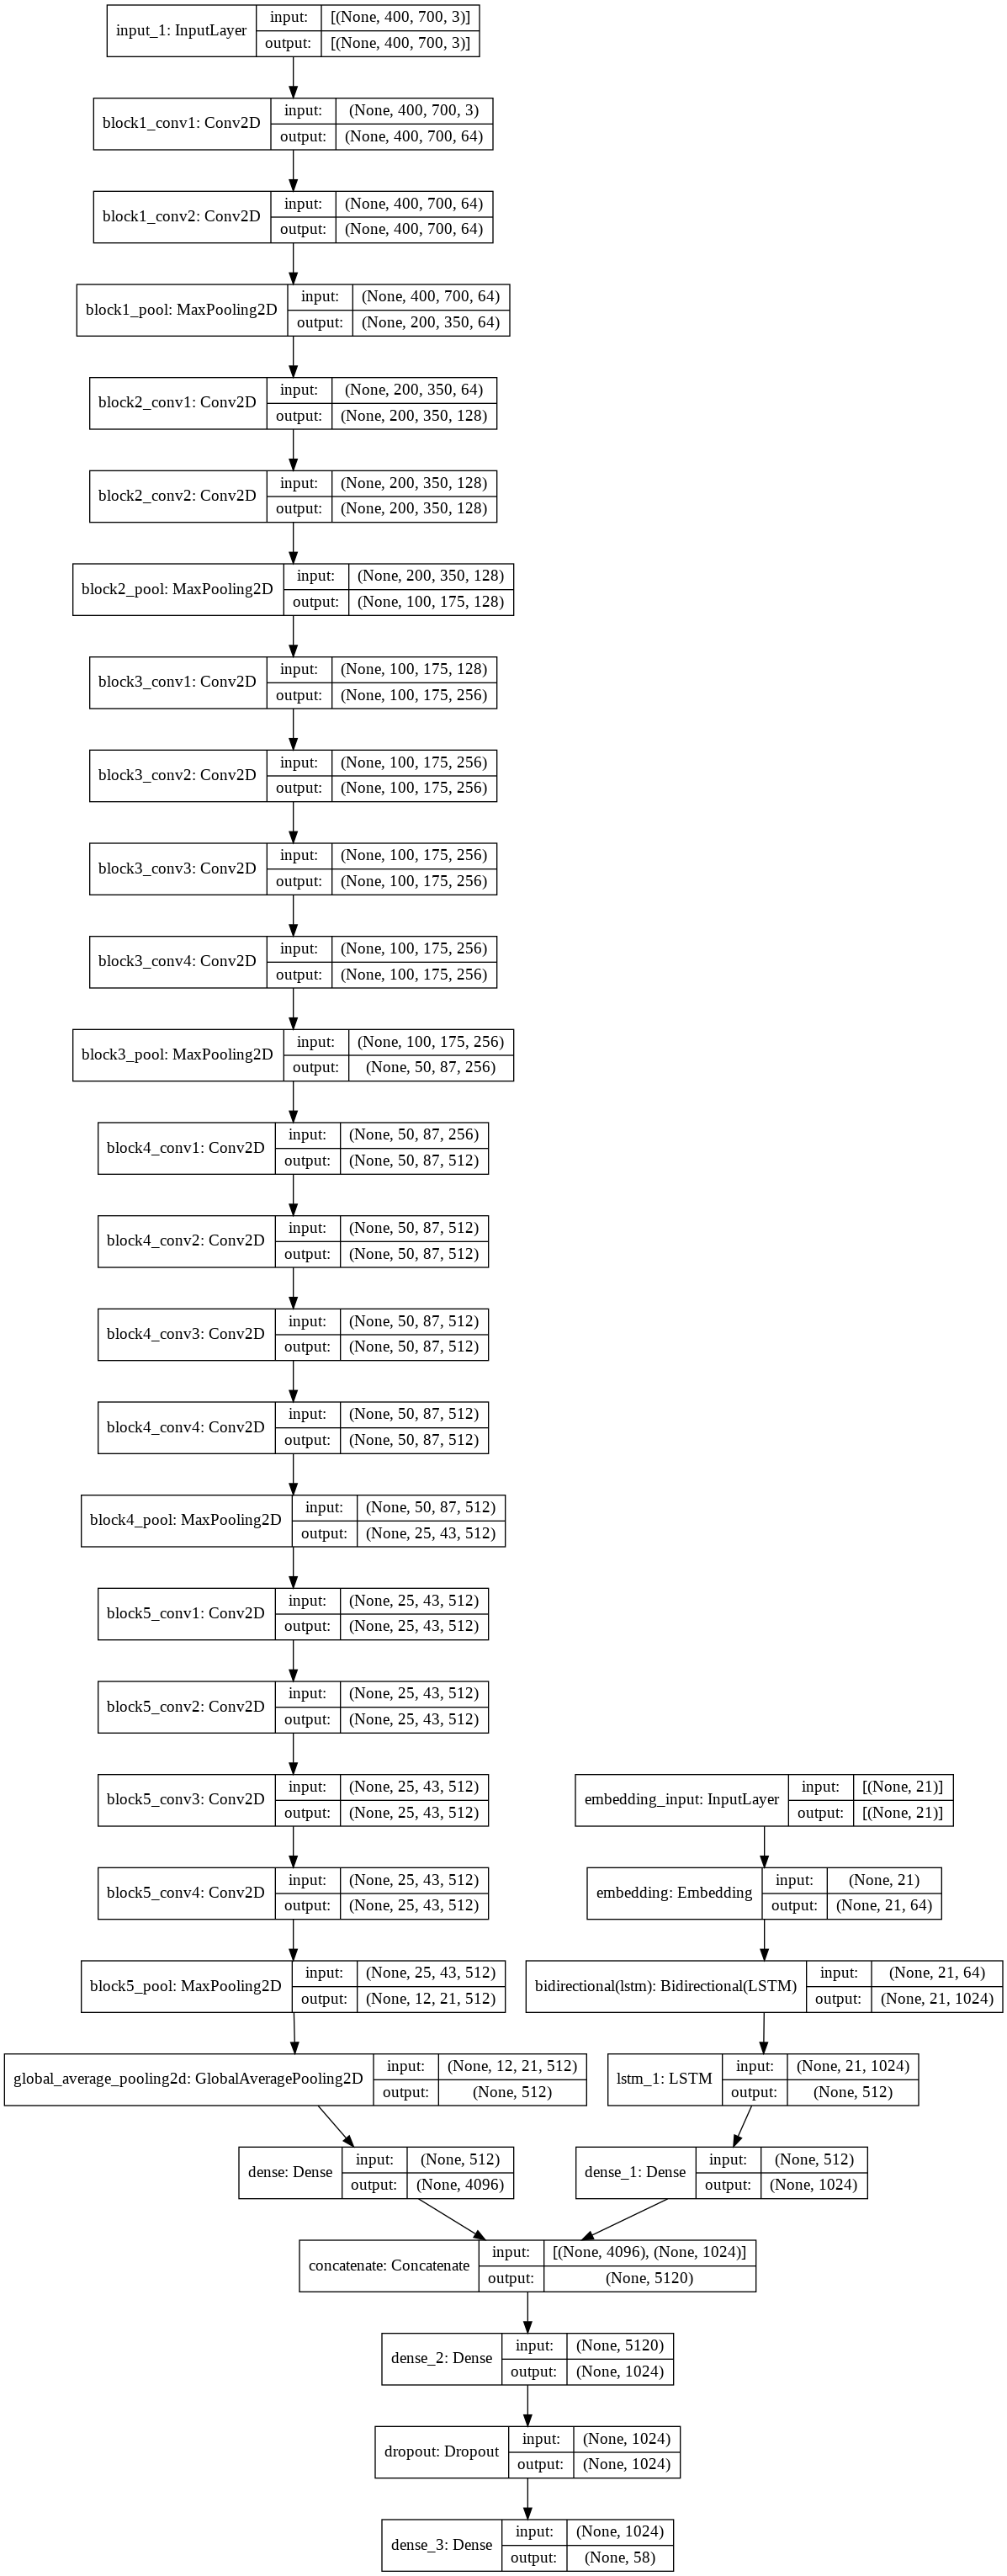

In [ ]:
#Let's visualize the structure of the model
plot_model(model_final,show_shapes=True, show_layer_names=True)

## Hyperparameters and Training of the model


In [ ]:
#Standard techniques were applied for this section of the code.

loss = tf.keras.losses.CategoricalCrossentropy()

lr = 1e-3 #era 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

metrics = ['accuracy']

model_final.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
callbacks = []

#Early stopping was applied and also a LR adapter callback,
#which helps us to get into the right minimum. 
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    callbacks.append(es_callback)
    
#LRPlateau
lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=0,
)

callbacks.append(lr_plateau_callback)

###TRAINING###
model_final.fit(train_gen,
                epochs=18,
                steps_per_epoch=len(train_arr)/bs, 
                validation_data=valid_gen,
                validation_steps=len(val_arr)/bs,
                callbacks = callbacks 
                )

Epoch 1/18
714/714 [==============================] - 1939s 3s/step - loss: 2.2427 - accuracy: 0.3828 - val_loss: 1.2657 - val_accuracy: 0.5046
Epoch 2/18
714/714 [==============================] - 1902s 3s/step - loss: 1.1409 - accuracy: 0.5574 - val_loss: 1.0988 - val_accuracy: 0.5564
Epoch 3/18
714/714 [==============================] - 1884s 3s/step - loss: 0.9909 - accuracy: 0.6082 - val_loss: 1.0356 - val_accuracy: 0.5805
Epoch 4/18
714/714 [==============================] - 1902s 3s/step - loss: 0.8948 - accuracy: 0.6402 - val_loss: 1.0251 - val_accuracy: 0.5902
Epoch 5/18
714/714 [==============================] - 1930s 3s/step - loss: 0.8524 - accuracy: 0.6525 - val_loss: 1.0165 - val_accuracy: 0.5946
Epoch 6/18
714/714 [==============================] - 1926s 3s/step - loss: 0.8122 - accuracy: 0.6679 - val_loss: 0.9831 - val_accuracy: 0.6024
Epoch 7/18
714/714 [==============================] - 1925s 3s/step - loss: 0.7710 - accuracy: 0.6877 - val_loss: 1.0602 - val_accuracy:

## Testing

*This section includes all the functions required for the realization of the predictions and the creation of the csv file for the submission*

In [ ]:
import json

#path_dataset='drive/My Drive/DeepLearning/Data/VQA_Dataset'

with open(cwd+'/test_questions.json', 'r') as f:
  test_json = json.load(f)
f.close()

In [ ]:
questions = []

for e in test_json:
    item = test_json.get(e)
    questions.append(item['question'])

In [ ]:
tokenized = tokenizer.texts_to_sequences(questions)
padded_question = pad_sequences(tokenized, maxlen=max_questions_length)

In [ ]:
for key, item in test_json.items():
  print(key, item)

Output streaming troncato alle ultime 5000 righe.
145071 {'question': 'What is the man doing?', 'image_id': '14507'}
154421 {'question': 'How many cats are there?', 'image_id': '15442'}
30932 {'question': 'Are they drinking tea?', 'image_id': '3093'}
126600 {'question': 'Are there lots of trees on the left?', 'image_id': '12660'}
151632 {'question': 'How many turtles?', 'image_id': '15163'}
114940 {'question': 'Is the dog right of woman?', 'image_id': '11494'}
126190 {'question': 'How many plants are evergreen?', 'image_id': '12619'}
173571 {'question': 'How many people are in this picture?', 'image_id': '17357'}
98941 {'question': 'Is the dog on a leash?', 'image_id': '9894'}
56370 {'question': 'Is it summer?', 'image_id': '5637'}
175040 {'question': 'Is the woman going to eat the pie slice?', 'image_id': '17504'}
27492 {'question': 'Who is laughing?', 'image_id': '2749'}
47012 {'question': 'How many ponds?', 'image_id': '4701'}
108211 {'question': 'Where is the tea set?', 'image_id':

In [ ]:
i=0
for item in test_json.values():
  #print(item['question'])
  item['question']=padded_question[i]
  i=i+1

In [ ]:
#Computation of the predictions on the test dataset
results={}
i=0
for key, item in test_json.items():
    img=retrieve_image(item['image_id'])
    question=item['question']
    question_id=key
    
    img=np.array(img)
    img = np.expand_dims(img, 0) 
    
    question=np.array(question)
    question = np.expand_dims(question, 0) 
    
    out_softmax = model_final.predict(x=[img,question])
    
    predicted_class = np.argmax(out_softmax, -1)
    predicted_class = predicted_class[0]
    
    results[question_id]=predicted_class
    
    i=i+1
    if(i%300==0):
        print('Done {}/{} predictions'.format(i,len(test_json)))

Done 300/6372 predictions
Done 600/6372 predictions
Done 900/6372 predictions
Done 1200/6372 predictions
Done 1500/6372 predictions
Done 1800/6372 predictions
Done 2100/6372 predictions
Done 2400/6372 predictions
Done 2700/6372 predictions
Done 3000/6372 predictions
Done 3300/6372 predictions
Done 3600/6372 predictions
Done 3900/6372 predictions
Done 4200/6372 predictions
Done 4500/6372 predictions
Done 4800/6372 predictions
Done 5100/6372 predictions
Done 5400/6372 predictions
Done 5700/6372 predictions
Done 6000/6372 predictions
Done 6300/6372 predictions


In [ ]:
#Here the function to create the csv is defined and then used
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')       #or str(key)    

In [ ]:
create_csv(results,'drive/My Drive/DeepLearning/Predictions')